# https://hrl.boyuai.com/chapter/2/dqn%E7%AE%97%E6%B3%95

In [12]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
import random

ModuleNotFoundError: No module named 'tqdm'

In [4]:
class ReplayBuffer:
    """经验回放池"""
    def __init__(self,capacity) -> None:
        self.buffer = collections.deque(maxlen=capacity)
    def add(self,state,action,reward,next_state,done):
        self.buffer.append((state,action,reward,next_state,done))
    def sample(self,batch_size):
        transitions = random.sample(self.buffer,batch_size)
        state,action,reward,next_state,done = zip(*transitions)
        return np.array(state),action,reward,np.array(next_state),done
    def size(self):
        return len(self.buffer)
    


In [5]:
class Qnet(torch.nn.Module):
    def __init__(self,state_dim,hidden_dim,action_dim):
        super(Qnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim,hidden_dim)
        self.fc2=torch.nn.Linear(hidden_dim,action_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
class DQN:
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,target_update,device) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device) # Q网络
        self.target_q_net = Qnet(state_dim,hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update # 目标网络更新频率
        self.count = 0
        self.device = device

    def take_action(self,state):
        if np.random.random()<self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state],dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        q_value = self.q_net(states).gather(1,actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1)
        q_targets = rewards + self.gamma*max_next_q_values*(1-dones)
        dqn_loss = torch.mean(F.mse_loss(q_value,q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

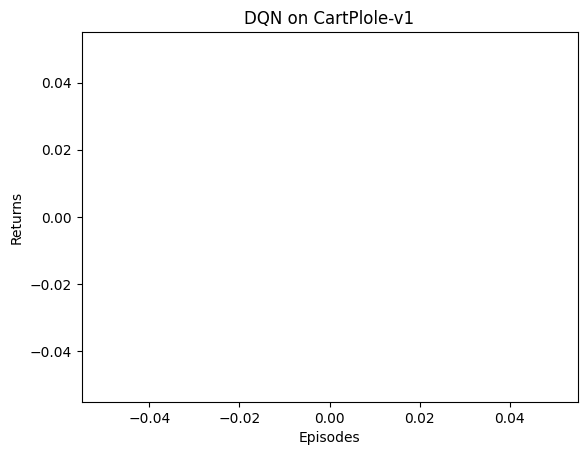

In [19]:
lr,num_eposodes,hidden_dim,gamma,epsilon,target_update,buffer_size,minimal_size,batch_size = 2e-3,500,128,0.98,0.01,10,10000,500,256
device  = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env = gym.make("CartPole-v1")
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device)
return_list = []
for i_episode in range(200):
    episode_return = 0
    state = env.reset()[0]
    done = False
    while not done:
        action = agent.take_action(state)
        next_state,reward,done,t,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        episode_return += reward

        # 当buffer数据的数量超过一定值后，才进行q网络的训练
        if replay_buffer.size() > minimal_size:
            b_s,b_a,b_r,b_ns,b_d = replay_buffer.sample(batch_size)
            transition_dict = {
                'states':b_s,
                'actions':b_a,
                'next_states':b_ns,
                'rewards' : b_r,
                'dones':b_d
            }
            agent.update(transition_dict)
    return_list.append(episode_return)
    print(f'episode{i_episode+1} is done')
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on CartPlole-v1')
plt.show()
torch.save({'model':agent.q_net.state_dict()},'CartPlole.pth')

In [21]:
q_net = Qnet(state_dim=state_dim,hidden_dim=hidden_dim,action_dim=action_dim)
q_net.load_state_dict(torch.load('CartPlole.pth')['model'])
q_net.to(device)
done = False
return_value = 0
env = gym.make('CartPole-v1',render_mode='human')
s  = env.reset()[0]
while not done:
    a = q_net(torch.tensor([s],dtype=torch.float).to(device)).argmax().item()
    n_s,r,done,t,info = env.step(a)
    s = n_s
    return_value += r
print(return_value)



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)